### Import neccesary libraries


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default") 

### Define the split type and stock name


In [34]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [35]:
split = 0
stock = 0 # FPT

## 1.Data preprocessing


In [36]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1308,2024-05-27,133000,133500,130600,132800,5157800,FPT
1309,2024-05-28,134000,137000,133100,137000,4625300,FPT
1310,2024-05-29,137100,138200,134800,135700,5837600,FPT
1311,2024-05-30,133800,135000,131900,135000,7261300,FPT


<Axes: >

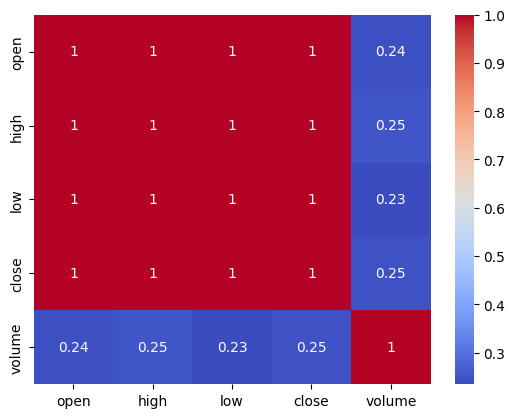

In [37]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [38]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


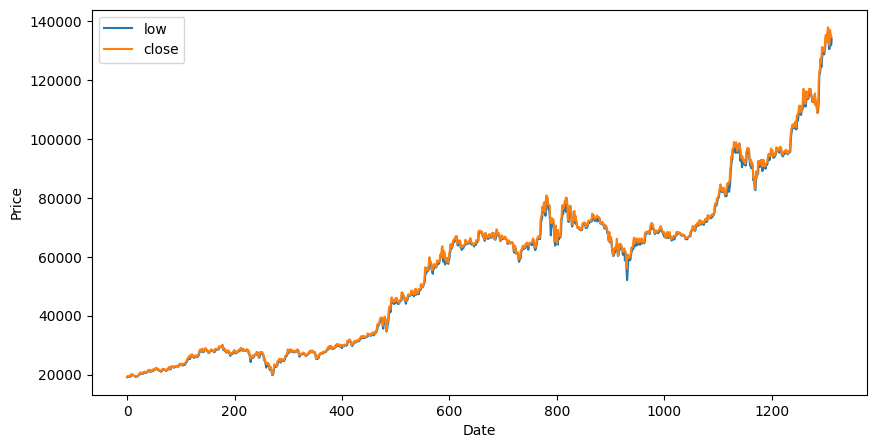

In [39]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [40]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [41]:
# Shape of the dataframe
df.shape

(1313, 2)

In [42]:
df.dtypes

low      int64
close    int64
dtype: object

In [43]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,56251.291698,56880.086824
std,27151.082839,27473.981127
min,19080.000000,19190.000000
25%,28120.000000,28410.000000
50%,62770.000000,63470.000000
75%,70940.000000,71450.000000
max,136100.000000,138000.000000


## 2. Train model


In [44]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [45]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [46]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(1.8386035496403492,
 0.9984225848793727,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 21624.1407585791)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.920
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.902
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


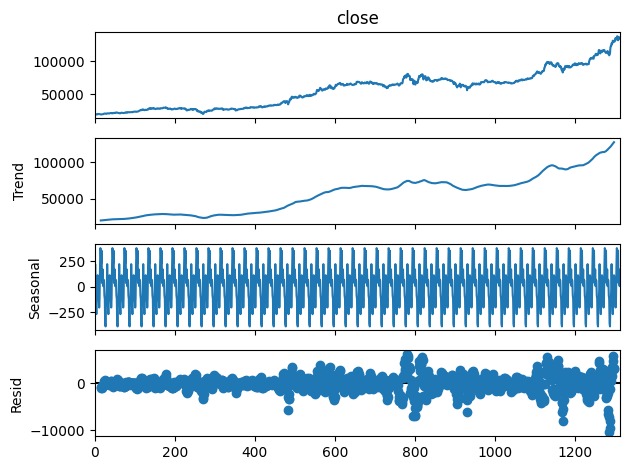

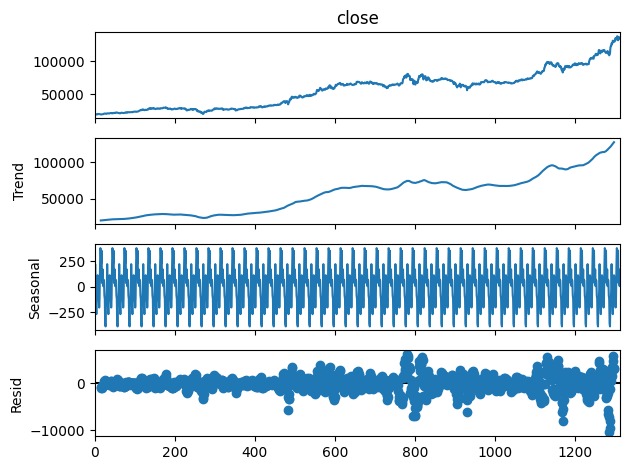

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-8.044223179266526,
 1.812686468576938e-12,
 22,
 1026,
 {'1%': -3.4367396063176874,
  '5%': -2.8643611157329905,
  '10%': -2.5682720836420705},
 16884.10281027981)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

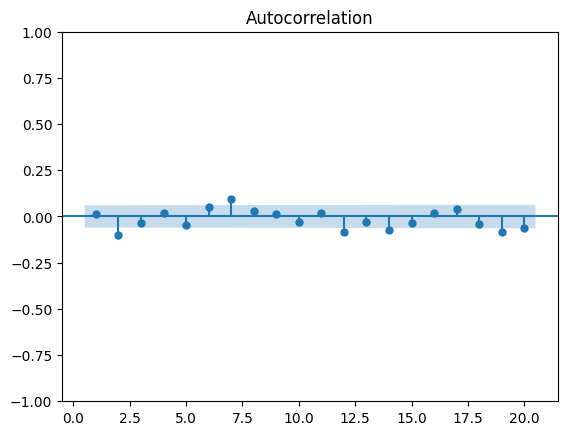

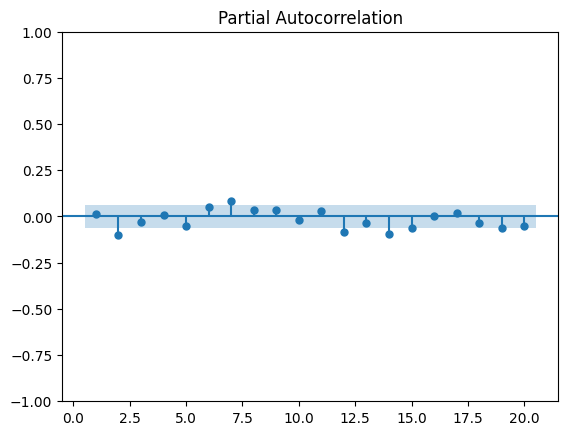

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=17263.800, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=17270.079, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=17271.795, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=17271.608, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=17270.869, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=17267.412, Time=0.46 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=17267.503, Time=0.47 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=17269.675, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=17267.582, Time=0.26 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=17267.853, Time=0.49 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=17268.218, Time=0.52 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=17268.580, Time=0.64 sec
 ARIMA(2,1,1)(1,0,1)[5] interce

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1050
Model:             SARIMAX(4, 1, 3)x(0, 0, [1], 5)   Log Likelihood               -8614.625
Date:                             Thu, 20 Jun 2024   AIC                          17247.251
Time:                                     07:01:46   BIC                          17291.851
Sample:                                          0   HQIC                         17264.163
                                            - 1050                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6668      0.048     13.861      0.000       0.573       0.761
ar.L2          0.6819      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(4, 1, 3),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([ 68933.42269902,  68818.7776223 ,  69097.49432609,  69388.4174653 ,
        69610.90918818,  69819.03857964,  69374.23171861,  69096.06786511,
        69029.91491898,  70088.88484221,  70551.54680631,  70566.64014889,
        70727.61642339,  70702.60568275,  70724.98748219,  71289.3405953 ,
        72005.34819895,  71695.40299102,  71036.3281251 ,  71204.29389471,
        71135.07015132,  71677.42166213,  71522.7842912 ,  71131.95285412,
        70955.37096189,  71849.51054542,  72019.48091819,  72569.26312673,
        72022.44639012,  72091.51433564,  71926.96843673,  73066.01917324,
        73862.74223784,  73457.34096597,  73064.56218883,  73055.38119524,
        73213.32700236,  73887.5778356 ,  73122.1824769 ,  73319.23258346,
        73970.67143893,  74062.67519378,  73974.12896778,  74443.2603874 ,
        75098.40739075,  77350.50244391,  76975.16380975,  77158.45056627,
        77349.30556533,  78379.10495831,  79322.30171549,  79691.01070889,
        79783.68582247,  

### Forecast the next 30/60/90 days


In [59]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [60]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [61]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[92584.90369376 92612.30664472 92710.54959984 92811.51305578
 92768.15761861 92871.70073819 92967.35115798 92992.49622033
 93049.41943269 93131.09710098 93157.16508224 93228.93304112
 93294.80897834 93326.47285399 93405.52926972 93457.40092322
 93499.66617908 93578.40329839 93621.04660146 93674.9401646
 93747.76444888 93787.12043468 93850.41856821 93914.67100056
 93956.0246128  94024.64689496 94080.54506125 94127.33174478
 94196.85976577 94246.7148508 ]


### Plotting the data


In [62]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

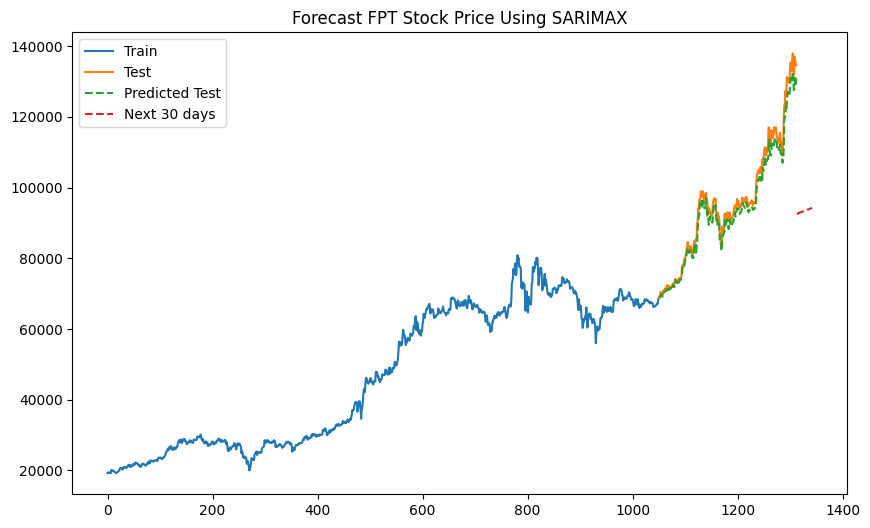

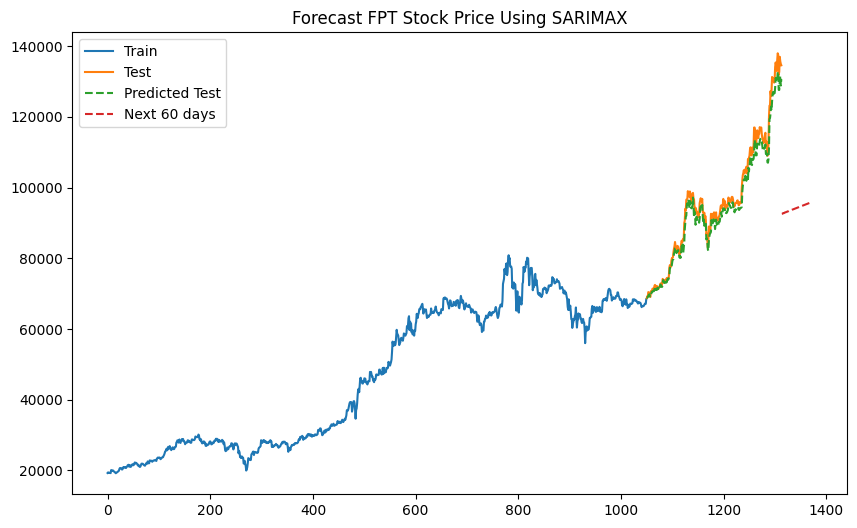

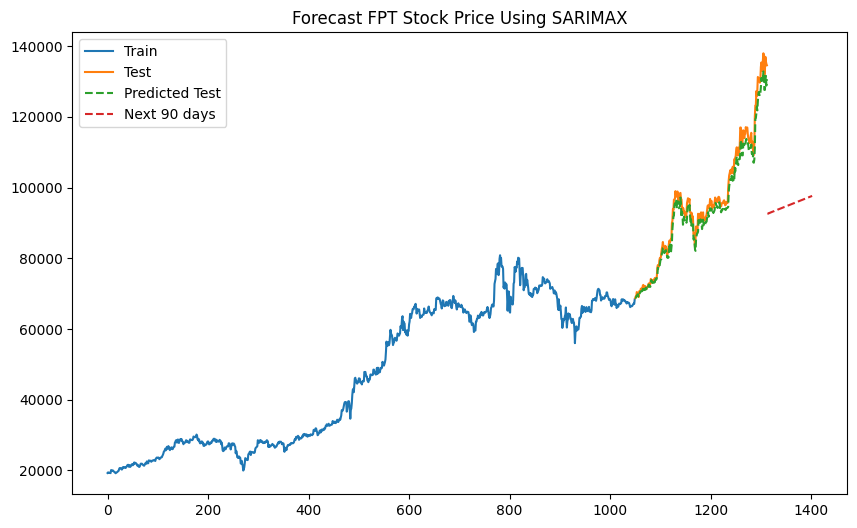

In [63]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [64]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 2689.8280850330593
MAE: 2194.4180233153083
MAPE: 2.135650693018323 %
